# Introduction
Here we will be creating a small set of functions that could be used to run different models
- preprocess the datas
- cleaning the datas
- select a model of machine learning
- train the model
-

In [1]:
import pandas as pd
import numpy as np
from numpy.lib.tests.test__datasource import malicious_files
from sklearn.model_selection import train_test_split

In [35]:

class DataProcessor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.X = None
        self.y = None


    # function to loas the data for that you need to have pandas imported as pd
    def load_data(self):
        """ here we will be loading the data from the path"""
        try:
            self.data = pd.read_csv(self.data_path, low_memory=False)
            print("Data loaded successfully")
        except FileNotFoundError:
            print("Error loading data {self.data_path}")

    def clean_data(self, drop_missing_values=False, replace_inf = True, Fill_value = False):
        """ here we will be cleaning the data"""
        if drop_missing_values:
            self.data.dropna(inplace=True)
        if replace_inf:
            self.data.replace([np.inf, -np.inf], Fill_value, inplace=True)

    def show_features(self):
        """ Display the features of the data"""
        if self.data is not None:
            print("features in the datasets: ")
            for feature in self.data.columns:
                print(f"-{feature}")
        else: print("No data loaded")

    def drop_features(self, columns_to_drop):
        """ Drop specific columns from the data
        args : colums_to_drop (list) : list of columns names to be dropped
        use the function show_features in order to checks the different features presents in the dataset
        """
        if self.data is not None:
            self.data.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
            print("Features dropped successfully")
        else: print("No data loaded. please load the data first")

    def split_data(self, target_column):
        """
        Splits the data into features (X) and target (y).
        Args: target_column (str): The name of the column to be used as the target variable.
        Returns: tuple: X (features), y (target)
        """
        if self.data is not None:
            if target_column in self.data.columns:
                self.X = self.data.drop(columns=[target_column])
                self.y = self.data[target_column]
                print(f"Data split into X (features) and y (target) using '{target_column}' as target.")
            else:
                print(f"Error: Column '{target_column}' not found in the dataset.")

        else:
            print("No data loaded. Please load the data first.")


    def detect_categorical(self, handle_nan="unknown"):
        """
        Detects categorical features in the dataset and identifies NaN values.
        Handles NaN values in the categorical features based on the chosen method.

        Args:
            handle_nan (str): How to handle NaN values in categorical features.
                              Options are "drop", "most_frequent", or "unknown".
        """
        if self.data is not None:
            # Detect categorical features
            categorical_features = self.data.select_dtypes(include=['object', 'category']).columns

            if len(categorical_features) == 0:
                print("No categorical features detected.")
                return

            print("Categorical Features and their NaN Information:")
            for feature in categorical_features:
                total_nan = self.data[feature].isna().sum()
                percentage_nan = (total_nan / len(self.data)) * 100

                print(f"- {feature}:")
                print(f"  NaN Count: {total_nan}")
                print(f"  Percentage of NaNs: {percentage_nan:.2f}%")

                # Handle NaN values based on the chosen option
                if total_nan > 0:  # Only handle if there are NaN values
                    if handle_nan == "drop":
                        self.data.dropna(subset=[feature], inplace=True)
                        print(f"  Action: Dropped rows with NaN in '{feature}'.")

                    elif handle_nan == "most_frequent":
                        most_frequent = self.data[feature].mode()[0]
                        # Assign the result back to the column
                        self.data[feature] = self.data[feature].fillna(most_frequent)
                        print(f"  Action: Replaced NaN with most frequent value '{most_frequent}'.")

                    elif handle_nan == "unknown":
                        # Assign the result back to the column
                        self.data[feature] = self.data[feature].fillna("Unknown")
                        print(f"  Action: Replaced NaN with 'Unknown'.")

                    else:
                        print(f"  Action: Invalid option '{handle_nan}'. No changes made for '{feature}'.")

            print("\nCategorical NaN handling completed.")
        else:
            print("No data loaded. Please load the data first.")

    def detect_numerical_issues(self):
        """
        Detects `NaN` and `inf` values in numerical features.
        Prints only the features with issues, showing their counts and percentages.
        Returns a list of features that have issues.

        Returns:
            list: A list of numerical feature names with issues (NaN or inf values).
        """
        if self.data is not None:
            # Detect numerical features
            numerical_features = self.data.select_dtypes(include=['number']).columns

            if len(numerical_features) == 0:
                print("No numerical features detected.")
                return []

            issues_found = []
            print("Numerical Features with NaN/Inf Issues:")
            for feature in numerical_features:
                # Detect NaN values
                total_nan = self.data[feature].isna().sum()
                percentage_nan = (total_nan / len(self.data)) * 100

                # Detect Inf values
                total_inf = self.data[feature].isin([np.inf, -np.inf]).sum()
                percentage_inf = (total_inf / len(self.data)) * 100

                # Process features with issues
                if total_nan > 0 or total_inf > 0:
                    issues_found.append(feature)
                    print(f"- {feature}:")
                    if total_nan > 0:
                        print(f"  NaN Count: {total_nan}, Percentage: {percentage_nan:.2f}%")
                    if total_inf > 0:
                        print(f"  Inf Count: {total_inf}, Percentage: {percentage_inf:.2f}%")

            if not issues_found:
                print("No NaN or Inf issues found in numerical features.")

            return issues_found
        else:
            print("No data loaded. Please load the data first.")
            return []

    def handle_numerical_issues(self, features, treatment="drop", replacement_value=None):
        """
        Handles numerical features with issues (`NaN` or `inf` values) based on the specified treatment.

        Args:
            features (list): List of numerical feature names to handle.
            treatment (str): The treatment to apply. Options are:
                             - "drop": Drops rows with issues in the specified features.
                             - "mean": Replaces issues with the column mean.
                             - "replace": Replaces issues with the specified `replacement_value`.
            replacement_value (float or int, optional): The value to use when `treatment` is "replace".

        Raises:
            ValueError: If an invalid `treatment` is provided.
        """
        if self.data is None:
            print("No data loaded. Please load the data first.")
            return

        for feature in features:
            if feature not in self.data.columns:
                print(f"Warning: Feature '{feature}' not found in the dataset. Skipping.")
                continue

            # Detect NaN and Inf values
            total_issues = self.data[feature].isna().sum() + self.data[feature].isin([np.inf, -np.inf]).sum()
            if total_issues == 0:
                print(f"No issues found in '{feature}'. Skipping.")
                continue

            print(f"Handling issues in '{feature}':")
            if treatment == "drop":
                # Drop rows with NaN or Inf
                self.data = self.data[~self.data[feature].isin([np.inf, -np.inf])]
                self.data.dropna(subset=[feature], inplace=True)
                print(f"  Action: Dropped rows with issues in '{feature}'.")

            elif treatment == "mean":
                # Replace issues with the column mean
                mean_value = self.data[~self.data[feature].isin([np.inf, -np.inf])][feature].mean()
                self.data[feature] = self.data[feature].replace([np.inf, -np.inf], mean_value)
                self.data[feature] = self.data[feature].fillna(mean_value)  # Corrected here
                print(f"  Action: Replaced issues with mean value '{mean_value:.2f}' in '{feature}'.")

            elif treatment == "replace":
                # Replace issues with a specific value
                if replacement_value is not None:
                    self.data[feature] = self.data[feature].replace([np.inf, -np.inf], replacement_value)
                    self.data[feature] = self.data[feature].fillna(replacement_value)  # Corrected here
                    print(f"  Action: Replaced issues with '{replacement_value}' in '{feature}'.")
                else:
                    print(f"  Error: No replacement value provided for '{feature}'. Skipping.")

            else:
                raise ValueError(f"Invalid treatment option '{treatment}' for '{feature}'.")

        print("\nNumerical issue handling completed.")

    def encode_categorical(self):
        """
        Encodes categorical features in the dataset using label encoding.
        Records the transformation details (original features and their categories)
        for later use in deployment or inverse transformation.
        """
        if self.data is not None:
            # Detect categorical features
            categorical_features = self.data.select_dtypes(include=['object', 'category']).columns

            if len(categorical_features) == 0:
                print("No categorical features detected for encoding.")
                return

            # Initialize or reset the encoding mapping
            self.encoding_mapping = {}

            print("Encoding categorical features using label encoding:")
            for feature in categorical_features:
                # Convert to category type if not already
                self.data[feature] = self.data[feature].astype('category')

                # Store the mapping of categories for the feature
                self.encoding_mapping[feature] = {
                    "categories": list(self.data[feature].cat.categories),
                    "index": self.data.columns.get_loc(feature)
                }

                # Apply label encoding
                self.data[feature] = self.data[feature].cat.codes
                print(f"  Label encoded '{feature}'. Categories: {self.encoding_mapping[feature]['categories']}")

            print("\nCategorical encoding completed. Transformation details recorded.")
        else:
            print("No data loaded. Please load the data first.")


    def scale_features(self, exclude_features=None, scaling_type="normalize"):
        """
        Scales all features in `X` using standardization or normalization, excluding specified features.
        Stores the scaled data in `self.X_scaled` and preserves `self.y`.

        Args:
            exclude_features (list, optional): List of feature names to exclude from scaling.
                                               Default is None (all features are scaled).
            scaling_type (str): The type of scaling to apply. Options are:
                                - "standardize": Scales to have zero mean and unit variance.
                                - "normalize": Scales to have values in the range [0, 1].
        """
        if hasattr(self, "X") and hasattr(self, "y"):
            # Ensure exclude_features is a list
            exclude_features = exclude_features or []

            # Identify features to scale, excluding specified ones
            features_to_scale = [f for f in self.X.columns if f not in exclude_features]

            if len(features_to_scale) == 0:
                print("No features to scale (all excluded).")
                return

            print(f"Scaling the following features using '{scaling_type}': {features_to_scale}")

            # Initialize a copy of X for scaling
            self.X_scaled = self.X.copy()

            if scaling_type == "standardize":
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                self.X_scaled[features_to_scale] = scaler.fit_transform(self.X[features_to_scale])
                print("  Standardization completed.")

            elif scaling_type == "normalize":
                from sklearn.preprocessing import MinMaxScaler
                scaler = MinMaxScaler()
                self.X_scaled[features_to_scale] = scaler.fit_transform(self.X[features_to_scale])
                print("  Normalization completed.")

            else:
                print(f"  Error: Invalid scaling type '{scaling_type}'. Use 'standardize' or 'normalize'.")
                return

            print("\nScaled data stored in `self.X_scaled`.")
        else:
            print("No feature data (X or y) detected. Please split the data into X and y first.")


In [29]:

""" main function to execute the script """
data = DataProcessor("../data/balanced_data.csv")



In [30]:
data.load_data()


Data loaded successfully


In [31]:
data.show_features()

features in the datasets: 
-Flow ID
-SrcIP
-DstIP
-SrcPort
-DstPort
-Protocol
-mTimestampStart
-mTimestampLast
-Flow Duration
-Flow Bytes/s
-Flow Packets/s
-Tot Fwd Pkts
-Tot Bwd Pkts
-Total Length of Fwd Packet
-Total Length of Bwd Packet
-Fwd Packet Length Min
-Fwd Packet Length Max
-Fwd Packet Length Mean
-Fwd Packet Length Std
-Bwd Packet Length Min
-Bwd Packet Length Max
-Bwd Packet Length Mean
-Bwd Packet Length Std
-Flow IAT Mean
-Flow IAT Min
-Flow IAT Max
-Flow IAT Stddev
-Fwd IAT Min
-Fwd IAT Max
-Fwd IAT Mean
-Fwd IAT Std
-Fwd IAT Tot
-Bwd IAT Min
-Bwd IAT Max
-Bwd IAT Mean
-Bwd IAT Std
-Bwd IAT Tot
-Fwd PSH flags
-Bwd PSH flags
-Fwd URG flags
-Bwd URG flags
-Fwd Header Length
-Bwd Header Length
-Fwd Packets/s
-Bwd Packets/s
-Packet Length Min
-Packet Length Max
-Packet Length Mean
-Packet Length Std
-Packet Length Variance
-FIN Flag Cnt
-SYN Flag Cnt
-RST Flag Cnt
-PSH Flag Cnt
-ACK Flag Cnt
-URG Flag Cnt
-CWR Flag Cnt
-ECE Flag Cnt
-Down/Up Ratio
-Average Packet Size
-Fwd 

In [32]:
columns_to_drop = ['Flow ID', 'SrcIP', 'DstIP','External_src', 'External_dst','Conn_state', 'Segment_src', 'Segment_dst', 'Expoid_src', 'Expoid_dst','mTimestampStart','mTimestampLast']
data.drop_features(columns_to_drop=columns_to_drop)

Features dropped successfully


In [33]:
data.detect_categorical(handle_nan="unknown")

Categorical Features and their NaN Information:
- Service:
  NaN Count: 1384681
  Percentage of NaNs: 42.10%
  Action: Replaced NaN with 'Unknown'.

Categorical NaN handling completed.


In [34]:
data.data["Service"]


0          Unknown
1             Http
2              TLS
3          Unknown
4          Unknown
            ...   
3289193       Http
3289194    Unknown
3289195       Http
3289196    Unknown
3289197       Http
Name: Service, Length: 3289198, dtype: object

In [97]:
# let's handle numerical datas
features_issues = data.detect_numerical_issues()


Numerical Features with NaN/Inf Issues:
- Flow Bytes/s:
  NaN Count: 152, Percentage: 0.00%
  Inf Count: 341401, Percentage: 10.38%
- Flow Packets/s:
  Inf Count: 341553, Percentage: 10.38%
- Flow IAT Mean:
  NaN Count: 340184, Percentage: 10.34%
- Flow IAT Min:
  NaN Count: 340184, Percentage: 10.34%
- Flow IAT Max:
  NaN Count: 340184, Percentage: 10.34%
- Flow IAT Stddev:
  NaN Count: 340184, Percentage: 10.34%


In [98]:
print(features_issues)

['Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Max', 'Flow IAT Stddev']


In [99]:
data.handle_numerical_issues(features_issues, treatment = "mean")

Handling issues in 'Flow Bytes/s':
  Action: Replaced issues with mean value '963270.09' in 'Flow Bytes/s'.
Handling issues in 'Flow Packets/s':
  Action: Replaced issues with mean value '12323.73' in 'Flow Packets/s'.
Handling issues in 'Flow IAT Mean':
  Action: Replaced issues with mean value '859579.90' in 'Flow IAT Mean'.
Handling issues in 'Flow IAT Min':
  Action: Replaced issues with mean value '620927.96' in 'Flow IAT Min'.
Handling issues in 'Flow IAT Max':
  Action: Replaced issues with mean value '2552450.62' in 'Flow IAT Max'.
Handling issues in 'Flow IAT Stddev':
  Action: Replaced issues with mean value '578091.07' in 'Flow IAT Stddev'.

Numerical issue handling completed.


In [100]:
# let's encode the categorical datas

data.encode_categorical()

Encoding categorical features using label encoding:
  Label encoded 'Service'. Categories: ['BGP', 'DCERPC', 'DNS', 'Http', 'LDAP', 'NTP', 'RDP', 'RTCP-APP', 'RTCP-RR', 'RTCP-RR~RTCP-SR', 'RTCP-SR', 'Rtp', 'SIP', 'SIP~Sip', 'SMB', 'SMTP', 'SSH', 'Sctp', 'Sip', 'Sip~SIP', 'TLS', 'dhcpv6', 'icmp', 'icmpv6', 'krb5']

Categorical encoding completed. Transformation details recorded.


In [101]:
# split data into dataset for the training and target
data.split_data(target_column='Label')

print(data.X.shape)
print(data.y.shape)

Data split into X (features) and y (target) using 'Label' as target.
(3289198, 82)
(3289198,)


In [102]:
data.scale_features(exclude_features=None, scaling_type="normalize")

Scaling the following features using 'normalize': ['SrcPort', 'DstPort', 'Protocol', 'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Min', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Max', 'Flow IAT Stddev', 'Fwd IAT Min', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Tot', 'Bwd IAT Min', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Tot', 'Fwd PSH flags', 'Bwd PSH flags', 'Fwd URG flags', 'Bwd URG flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',

# Creatigng the machine learning class

In [189]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Import the XGBoost library
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [174]:
class MLModel:
    def __init__(self, data, target_column):
        """
        Initialize the MLModel class with dataset and target variable.

        Args:
            data (pd.DataFrame): The dataset containing features and target.
            target_column (str): The name of the target column in the dataset.
        """
        self.data = data
        self.target_column = target_column
        self.model = None  # Placeholder for the machine learning model
        self.X_train, self.X_val, self.X_test = [None] * 3
        self.y_train, self.y_val, self.y_test = [None] * 3

    def preprocess(self, test_size=0.2, val_size=0.1, random_state=42):
        """
        Split the data into training, validation, and testing sets.
            test_size (float): Proportion of the dataset to include in the test split.
            val_size (float): Proportion of the training set to use for validation.
            random_state (int): Random state for reproducibility.
        """
        # Use self.data and self.target_column to extract features and target
        X = self.data
        y = self.target_column

        # Split into training+validation and test sets
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        # Split training+validation set into training and validation sets
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=val_size, random_state=random_state
        )

    def set_model(self, model_class, model_params=None):
        """
        Set the machine learning model to use.

        Args:
            model_class: The class of the machine learning model (e.g., RandomForestClassifier).
            model_params (dict): A dictionary of parameters to pass to the model.
        """
        if model_params is None:
            model_params = {}  # Default to an empty dictionary if no parameters provided
        self.model = model_class(**model_params)


    def train(self):
        """
        Train the machine learning model on the training data.
        """
        if self.model is None:
            raise ValueError("Model not set. Use the 'set_model' method to define a model.")
        if self.X_train is None or self.y_train is None:
            raise ValueError("Training data not prepared. Run the 'preprocess' method first.")

        print("Training the model...")
        self.model.fit(self.X_train, self.y_train)
        print("Model training complete.")

    def validate(self):
        """
        Validate the model on the validation data.
            float: Accuracy score of the model on the validation set.
            ValueError: If the model is not trained or validation data is missing.
        """
        if self.model is None:
            raise ValueError("Model not trained. Use the 'train' method first.")
        if self.X_val is None or self.y_val is None:
            raise ValueError("Validation data not prepared. Run the 'preprocess' method first.")

        print("Validating the model...")
        predictions = self.model.predict(self.X_val)
        accuracy = accuracy_score(self.y_val, predictions)
        print(f"Validation Accuracy: {accuracy:.4f}")
        return accuracy

    def test(self):
        """
        Test the model on the test data.
        float: Accuracy score of the model on the test set.
        ValueError: If the model is not trained or test data is missing.
        """
        if self.model is None:
            raise ValueError("Model not trained. Use the 'train' method first.")
        if self.X_test is None or self.y_test is None:
            raise ValueError("Test data not prepared. Run the 'preprocess' method first.")

        print("Testing the model...")
        predictions = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, predictions)
        print(f"Test Accuracy: {accuracy:.4f}")
        return accuracy


    def plot_confusion_matrix(self, dataset='test'):
        """
        Plot the confusion matrix for the model predictions.
            dataset (str): Which dataset to evaluate ('test' or 'val').
        """
        if dataset == 'test':
            X, y = self.X_test, self.y_test
        elif dataset == 'val':
            X, y = self.X_val, self.y_val
        else:
            raise ValueError("Invalid dataset. Use 'test' or 'val'.")

        predictions = self.model.predict(X)
        ConfusionMatrixDisplay.from_predictions(y, predictions)

    def plot_roc_curve(self, dataset='test'):
        """
        Plot the ROC curve for the model predictions.
        Args:
            dataset (str): Which dataset to evaluate ('test' or 'val').
        """
        if dataset == 'test':
            X, y = self.X_test, self.y_test
        elif dataset == 'val':
            X, y = self.X_val, self.y_val
        else:
            raise ValueError("Invalid dataset. Use 'test' or 'val'.")

        # Check if the model supports predict_proba
        if hasattr(self.model, "predict_proba"):
            y_proba = self.model.predict_proba(X)[:, 1]  # Probability of the positive class
        elif hasattr(self.model, "decision_function"):
            y_proba = self.model.decision_function(X)  # Decision scores
        else:
            raise ValueError("The model does not support probability predictions or decision function.")

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y, y_proba)

        # Plot ROC curve with label
        display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        display.plot(label=f"ROC Curve ({dataset} set)")


    def plot_precision_recall_curve(self, dataset='test'):
        """
        Plot the precision-recall curve for the model predictions.
        Args:
            dataset (str): Which dataset to evaluate ('test' or 'val').
        """
        if dataset == 'test':
            X, y = self.X_test, self.y_test
        elif dataset == 'val':
            X, y = self.X_val, self.y_val
        else:
            raise ValueError("Invalid dataset. Use 'test' or 'val'.")

        y_proba = self.model.predict_proba(X)[:, 1]
        precision, recall, _ = precision_recall_curve(y, y_proba)
        PrecisionRecallDisplay(precision=precision, recall=recall).plot()




    def compute_metrics(self, dataset='test'):
        """
        Compute key metrics derived from the confusion matrix:
        Accuracy, Precision, Recall, and F1-Score.
        """
        # Choose the appropriate dataset
        if dataset == 'test':
            X, y = self.X_test, self.y_test
        elif dataset == 'val':
            X, y = self.X_val, self.y_val
        else:
            raise ValueError("Invalid dataset. Use 'test' or 'val'.")

        # Get predictions
        predictions = self.model.predict(X)

        # Compute metrics
        metrics = {
            'Accuracy': accuracy_score(y, predictions),
            'Precision': precision_score(y, predictions, zero_division=0),
            'Recall': recall_score(y, predictions, zero_division=0),
            'F1-Score': f1_score(y, predictions, zero_division=0)
        }

        # Print metrics for quick review
        print(f"Metrics for {dataset} dataset:")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

        return metrics



In [178]:
ml = MLModel(data.X_scaled, data.y )

In [179]:
# Define parameters for the XGBClassifier
xgb_params = {
    'n_estimators': 150,
    'learning_rate': 0.05,
    'max_depth': 8,
    'random_state': 42,
    # 'use_label_encoder': False,
    'eval_metric': 'logloss'
}

In [180]:

# Set the model using the dictionary of parameters
ml.set_model(XGBClassifier, xgb_params)

from sklearn.ensemble import RandomForestClassifier

 Define parameters for the RandomForestClassifier
rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42
}

 Set the model using the dictionary of parameters
ml.set_model(RandomForestClassifier, rf_params)


from sklearn.linear_model import LogisticRegression

 Define parameters for Logistic Regression
lr_params = {
    'penalty': 'l2',
    'C': 1.0,
    'solver': 'liblinear',
    'random_state': 42
}

 Set the model using the dictionary of parameters
ml.set_model(LogisticRegression, lr_params)




In [181]:
ml.preprocess(test_size=0.2, val_size=0.1, random_state=42)

In [182]:
ml.train()

Training the model...
Model training complete.


In [183]:
ml.validate()

Validating the model...
Validation Accuracy: 0.9998


0.999764380396449

In [184]:
ml.test()

Testing the model...
Test Accuracy: 0.9998


0.9997659005229235

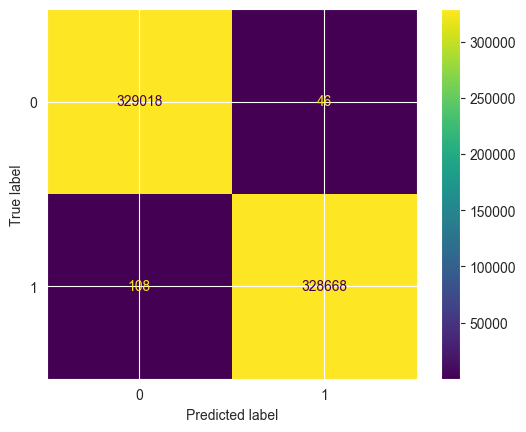

In [185]:
ml.plot_confusion_matrix(dataset='test')

'\nTrue Negatives (Top-left):\nLabel: 0 predicted as 0\nInterpretation: These are the instances where the model correctly predicted class 0.\n\nFalse Positives (Top-right):\nLabel: 0 predicted as 1\nInterpretation: These are the instances where the model incorrectly predicted class 1 when the true label was 0.\n\nFalse Negatives (Bottom-left):\nLabel: 1 predicted as 0\nInterpretation: These are the instances where the model incorrectly predicted class 0 when the true label was 1.\n\nTrue Positives (Bottom-right):\nLabel: 1 predicted as 1\nInterpretation: These are the instances where the model correctly predicted class 1.\n\n'

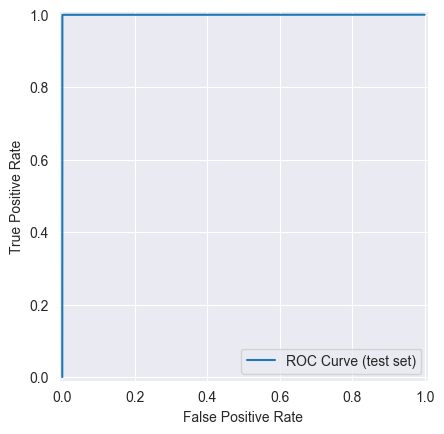

In [186]:
ml.plot_roc_curve(dataset='test')

"""
True Negatives (Top-left):
Label: 0 predicted as 0
Interpretation: These are the instances where the model correctly predicted class 0.

False Positives (Top-right):
Label: 0 predicted as 1
Interpretation: These are the instances where the model incorrectly predicted class 1 when the true label was 0.

False Negatives (Bottom-left):
Label: 1 predicted as 0
Interpretation: These are the instances where the model incorrectly predicted class 0 when the true label was 1.

True Positives (Bottom-right):
Label: 1 predicted as 1
Interpretation: These are the instances where the model correctly predicted class 1.

"""

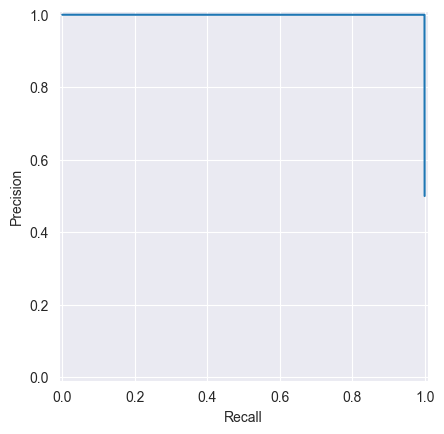

In [187]:
ml.plot_precision_recall_curve(dataset='test')

In [191]:
metrics = ml.compute_metrics(dataset='test')

Metrics for test dataset:
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9997
F1-Score: 0.9998
